# Análise e Exploração do Conjunto de dados German Credit

Este conjunto de dados foi criado pela reintegração do atributo 'risco de crédito' do conjunto de dados 'Dados de crédito alemães' do Professor Dr. Hans Hofmann no Repositório de aprendizado de máquina da UCI ( https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) ) no conjunto de dados refinado publicado pela UCI ( https://www.kaggle.com/datasets/uciml/german-credit) .

Fonte: https://www.kaggle.com/datasets/benjaminmcgregor/german-credit-data-set-with-credit-risk

Objetivo: Avaliar o risco de crédito de clientes

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import choice

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d benjaminmcgregor/german-credit-data-set-with-credit-risk


Dataset URL: https://www.kaggle.com/datasets/benjaminmcgregor/german-credit-data-set-with-credit-risk
License(s): Attribution 4.0 International (CC BY 4.0)
german-credit-data-set-with-credit-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip german-credit-data-set-with-credit-risk.zip


Archive:  german-credit-data-set-with-credit-risk.zip
replace german_credit_data_updated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: german_credit_data_updated.csv  
replace reintegrate_credit_score.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: reintegrate_credit_score.py  


In [5]:
df_german_credit = pd.read_csv('german_credit_data_updated.csv', index_col=0)

df_german_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Credit Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [6]:
df_german_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954 entries, 0 to 953
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               954 non-null    int64 
 1   Sex               954 non-null    object
 2   Job               954 non-null    int64 
 3   Housing           954 non-null    object
 4   Saving accounts   779 non-null    object
 5   Checking account  576 non-null    object
 6   Credit amount     954 non-null    int64 
 7   Duration          954 non-null    int64 
 8   Purpose           954 non-null    object
 9   Credit Risk       954 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 82.0+ KB


In [7]:
df_german_credit.describe()

,Age,Job,Credit amount,Duration,Credit Risk
count,954.000000,954.000000,954.000000,954.000000,954.000000
mean,35.501048,1.909853,3279.112159,20.780922,1.302935
std,11.379668,0.649681,2853.315158,12.046483,0.459768
min,19.000000,0.000000,250.000000,4.000000,1.000000
25%,27.000000,2.000000,1360.250000,12.000000,1.000000
50%,33.000000,2.000000,2302.500000,18.000000,1.000000
75%,42.000000,2.000000,3975.250000,24.000000,2.000000
max,75.000000,3.000000,18424.000000,72.000000,2.000000


In [8]:
df_german_credit.rename(columns={
    'Age': 'age',
    'Sex': 'sex',
    'Job': 'job',
    'Housing': 'housing',
    'Saving accounts': 'saving_accounts',
    'Checking account': 'checking_account',
    'Credit amount': 'credit_amount',
    'Duration': 'duration',
    'Purpose': 'purpose',
    'Credit Risk': 'credit_risk'
}, inplace=True)

In [9]:
df_german_credit.columns = df_german_credit.columns.str.strip().str.lower().str.replace(' ', '_')
df_german_credit.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [10]:
print(df_german_credit['housing'].unique())
print(df_german_credit['purpose'].unique())
print(df_german_credit['saving_accounts'].unique())
print(df_german_credit['checking_account'].unique())
print(df_german_credit['credit_risk'].unique())

['own' 'free' 'rent']
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
[nan 'little' 'quite rich' 'rich' 'moderate']
['little' 'moderate' nan 'rich']
[1 2]


##### Tratando valores faltantes de Checking account
Vamos substituir os valores faltantes proporcionalmente utilizando os valores que já conhecemos.

In [11]:
df_german_credit['checking_account'].unique()


array(['little', 'moderate', nan, 'rich'], dtype=object)

In [12]:
df_german_credit['checking_account'].value_counts()

,count
checking_account,
little,261
moderate,256
rich,59


In [13]:
df_german_credit['checking_account'].isnull().sum()

378

In [14]:
distribution = df_german_credit['checking_account'].value_counts(normalize=True)
missing_values = choice(distribution.index, size=df_german_credit['checking_account'].isna().sum(), p=distribution.values)
df_german_credit.loc[df_german_credit['checking_account'].isna(), 'checking_account'] = missing_values

In [15]:
df_german_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954 entries, 0 to 953
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               954 non-null    int64 
 1   sex               954 non-null    object
 2   job               954 non-null    int64 
 3   housing           954 non-null    object
 4   saving_accounts   779 non-null    object
 5   checking_account  954 non-null    object
 6   credit_amount     954 non-null    int64 
 7   duration          954 non-null    int64 
 8   purpose           954 non-null    object
 9   credit_risk       954 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 82.0+ KB


In [16]:
df_german_credit['checking_account'].unique()

array(['little', 'moderate', 'rich'], dtype=object)

##### Tratando valores faltantes de Saving Accounts
Para o Saving Accounts podemos  utilizar um modelo para prever qual seria o valor nesta coluna para isso precisamos tratar os dados dentro do nosso conjunto.

In [17]:
df_german_credit['saving_accounts'].isnull().sum()

175

In [18]:
df_german_credit['saving_accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [19]:
df_german_credit['saving_accounts'].value_counts()

,count
saving_accounts,
little,576
moderate,96
quite rich,60
rich,47


In [20]:
df_german_credit.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,moderate,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [21]:
df_german_credit_encoded = df_german_credit.copy()


In [22]:
df_german_credit_encoded.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,moderate,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [23]:
housing_mapping = {'free': 0, 'rent': 1, 'own': 2}
saving_accounts_mapping = {'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}
checking_account_mapping = {'little': 0, 'moderate': 1, 'rich': 2}
purpose_mapping = {
    'radio/TV': 0,
    'education': 1,
    'furniture/equipment': 2,
    'car': 3,
    'business': 4,
    'domestic appliances': 5}

df_german_credit_encoded['housing'] = df_german_credit_encoded['housing'].map(housing_mapping)
df_german_credit_encoded['saving_accounts'] = df_german_credit_encoded['saving_accounts'].map(saving_accounts_mapping)
df_german_credit_encoded['checking_account'] = df_german_credit_encoded['checking_account'].map(checking_account_mapping)
df_german_credit_encoded['purpose'] = df_german_credit_encoded['purpose'].map(purpose_mapping)

df_german_credit_encoded['credit_risk'] = df_german_credit_encoded['credit_risk'].apply(lambda x: 0 if x == 1 else 1) # Trocando valores do Credit Risk para 1 em 0 e 2 em 1, isso vai ajudar os nossos estudos.

In [24]:
df_german_credit_encoded.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,male,2,2,NaN,0,1169,6,0.0,0
1,22,female,2,2,0.0,1,5951,48,0.0,1
2,49,male,1,2,0.0,1,2096,12,1.0,0
3,45,male,2,0,0.0,0,7882,42,2.0,0
4,53,male,2,0,0.0,0,4870,24,3.0,1


In [25]:
label_encoder = LabelEncoder()
categorical_columns = ['sex', 'purpose']
for col in categorical_columns:
    df_german_credit_encoded[col] = label_encoder.fit_transform(df_german_credit_encoded[col])

train_data_saving_accounts = df_german_credit_encoded[df_german_credit_encoded['saving_accounts'].notna()]
test_data_saving_accounts = df_german_credit_encoded[df_german_credit_encoded['saving_accounts'].isna()]

X_train_saving_accounts = train_data_saving_accounts.drop('saving_accounts', axis=1)
y_train_saving_accounts = train_data_saving_accounts['saving_accounts']

model = RandomForestClassifier()
model.fit(X_train_saving_accounts, y_train_saving_accounts)

df_german_credit_encoded.loc[
    df_german_credit_encoded['saving_accounts'].isna(), 'saving_accounts'
] = model.predict(test_data_saving_accounts.drop('saving_accounts', axis=1))

df_german_credit_encoded.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,1,2,2,0.0,0,1169,6,0,0
1,22,0,2,2,0.0,1,5951,48,0,1
2,49,1,1,2,0.0,1,2096,12,1,0
3,45,1,2,0,0.0,0,7882,42,2,0
4,53,1,2,0,0.0,0,4870,24,3,1


In [26]:
df_german_credit.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,moderate,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [27]:
df_german_credit_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954 entries, 0 to 953
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               954 non-null    int64  
 1   sex               954 non-null    int64  
 2   job               954 non-null    int64  
 3   housing           954 non-null    int64  
 4   saving_accounts   954 non-null    float64
 5   checking_account  954 non-null    int64  
 6   credit_amount     954 non-null    int64  
 7   duration          954 non-null    int64  
 8   purpose           954 non-null    int64  
 9   credit_risk       954 non-null    int64  
dtypes: float64(1), int64(9)
memory usage: 82.0 KB


# Visualização

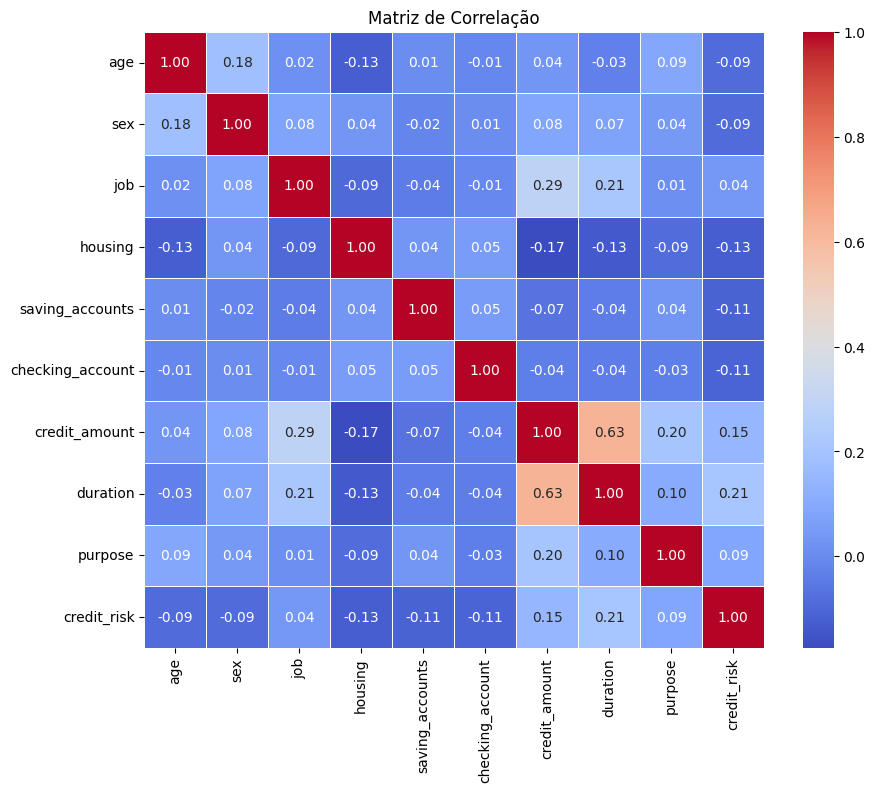

In [28]:
corr_matrix = df_german_credit_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

#### Analise: Matrix Correlação

A matriz de correlação revela algumas relações interessantes no conjunto de dados:

Relação entre duration e credit_amount: A correlação positiva entre essas variáveis sugere que créditos de maior valor tendem a exigir prazos mais longos para quitação. Esse padrão pode refletir práticas de crédito em que montantes maiores são parcelados para manter as mensalidades acessíveis.

Relação entre credit_risk e duration: A correlação significativa indica que prazos mais longos estão associados a um risco de crédito mais elevado. Isso pode estar relacionado à incerteza adicional e à maior probabilidade de inadimplência à medida que o tempo aumenta.

Idade e Risco de Crédito: Observa-se que clientes mais velhos geralmente apresentam menor risco de crédito. Esse padrão pode refletir maior estabilidade financeira ou histórico de crédito consolidado entre clientes mais experientes.

Habitação e Risco de Crédito: Clientes que possuem casa própria (own) apresentam menor risco de crédito. Isso pode estar relacionado à percepção de maior segurança financeira e menor probabilidade de inadimplência desses indivíduos.

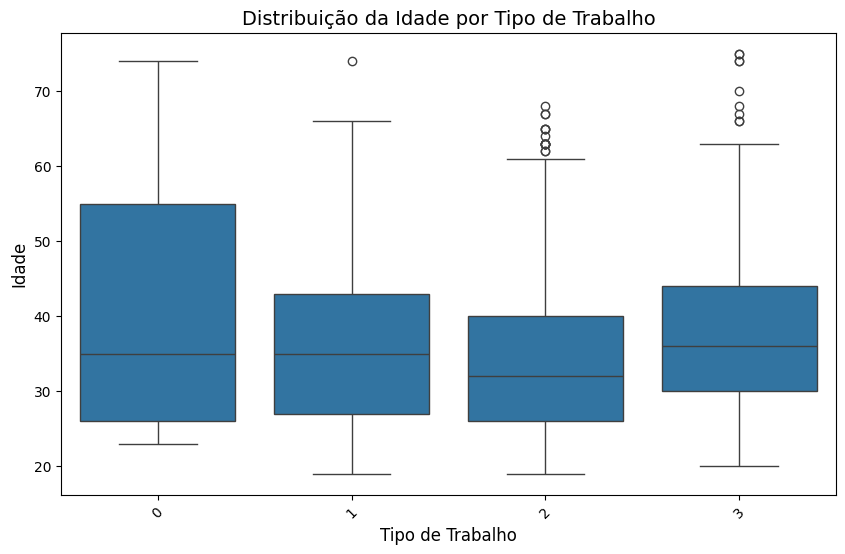

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='job', y='age', data=df_german_credit_encoded)

plt.title('Distribuição da Idade por Tipo de Trabalho', fontsize=14)
plt.xlabel('Tipo de Trabalho', fontsize=12)
plt.ylabel('Idade', fontsize=12)

plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição da Idade por Tipo de Trabalho

O tipo de trabalho 0 possui uma maior faixa etária, com idades variando de aproximadamente 27 a 55 anos. Isso sugere uma diversidade maior de perfis, o que pode refletir uma ocupação mais acessível, menos especializada, ou que oferece mais flexibilidade.

A mediana do tipo de trabalho 2, abaixo dos 35 anos, revela que esse trabalho tende a atrair uma força de trabalho mais jovem, possivelmente devido à natureza das funções ou requisitos de habilidades que envolvem menor experiência ou flexibilidade maior em termos de idade.

O tipo de trabalho 3 mostra que a maior parte das pessoas nesta categoria tem cerca de 63 anos, mas também apresenta outliers de idades mais avançadas, como 65, 67 e até 77 anos. Isso pode indicar uma ocupação que, embora tenha uma tendência para trabalhadores mais velhos, ainda permite que pessoas fora da faixa média de idade também ocupem esse espaço.


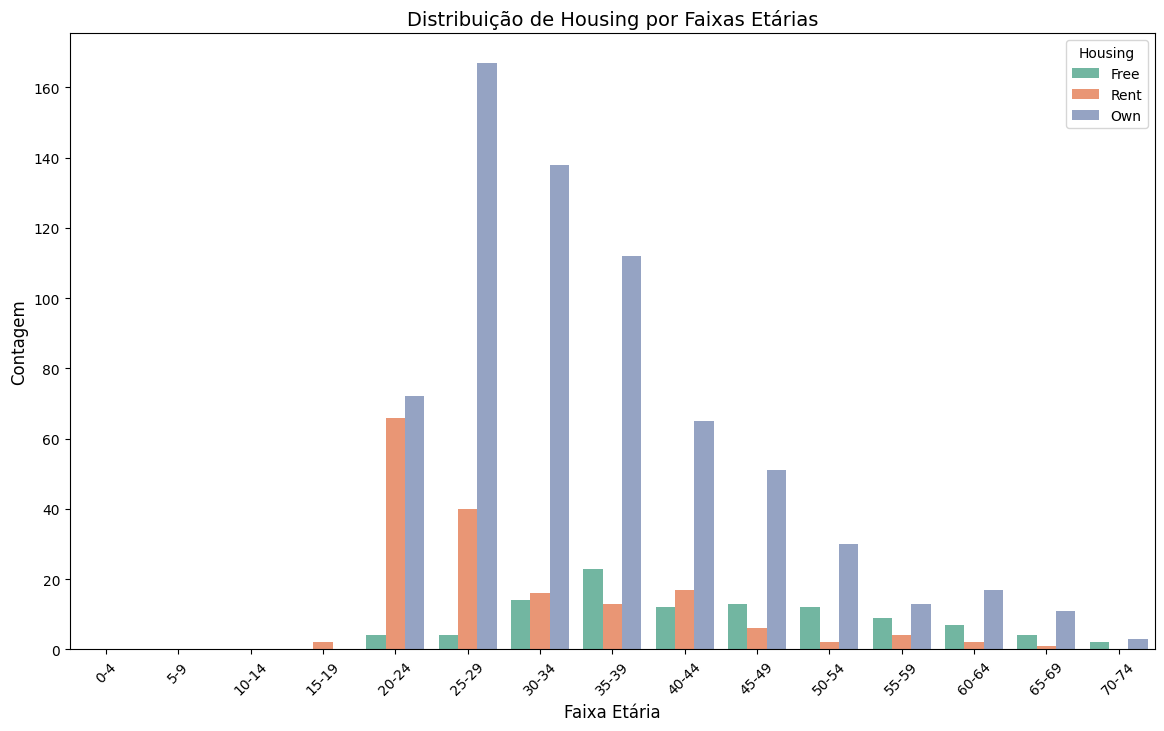

In [30]:
df_german_credit_encoded['age_group'] = pd.cut(
    df_german_credit_encoded['age'],
    bins=range(0, df_german_credit_encoded['age'].max() + 5, 5),
    right=False,
    labels=[f"{i}-{i+4}" for i in range(0, df_german_credit_encoded['age'].max(), 5)]
)

plt.figure(figsize=(14, 8))
sns.countplot(
    data=df_german_credit_encoded,
    x='age_group',
    hue='housing',
    palette='Set2'
)

plt.title('Distribuição de Housing por Faixas Etárias', fontsize=14)
plt.xlabel('Faixa Etária', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend(title='Housing', labels=['Free', 'Rent', 'Own'], loc='upper right')

plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Housing por Faixas Etárias

O gráfico revela que até os 29 anos é incomum que as pessoas tenham moradia gratuita. Esse cenário começa a mudar após os 30 anos, quando o índice de aluguel diminui e a moradia gratuita se torna mais comum. Isso pode indicar que, com o passar do tempo, muitas pessoas compram suas próprias casas, enquanto aquelas que não conseguem acabam sem recursos para pagar aluguel ou adquirir uma moradia própria.

O aluguel é claramente predominante antes dos 30 anos, sugerindo que, nesta fase da vida, as pessoas ainda não possuem recursos suficientes para adquirir uma casa, mas conseguem arcar com as despesas de moradia alugada.

Por outro lado, a compra de imóveis começa a se destacar a partir dos 25 anos, evidenciando que, a partir dessa idade, muitas pessoas aparentam alcançar uma maior estabilidade financeira e pessoal. Isso as permite assumir compromissos de longo prazo, como a aquisição de uma casa própria. Além disso, sendo jovens, ainda dispõem de tempo para quitar financiamentos, o que torna essa decisão mais viável.


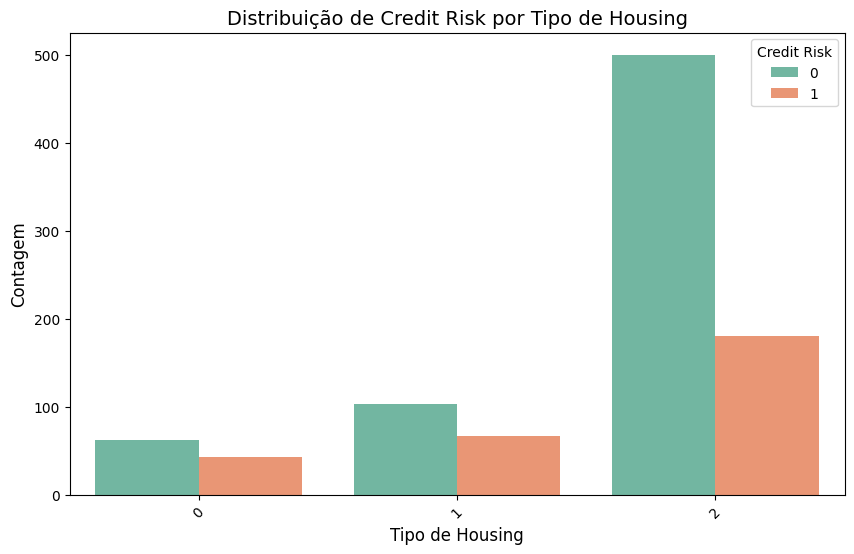

In [31]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df_german_credit_encoded, x='housing', hue='credit_risk', palette='Set2')

plt.title('Distribuição de Credit Risk por Tipo de Housing', fontsize=14)
plt.xlabel('Tipo de Housing', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend(title='Credit Risk', loc='upper right')

plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Credit Risk por Tipo de Housing

Pessoas com o tipo de moradia free (0) indicam uma provável falta de recursos financeiros para pagamento do crédito, o que se reflete em um número proporcionalmente maior de indivíduos com credit_risk = 0 em comparação com credit_risk = 1. Essa situação pode indicar maior vulnerabilidade financeira.

Já no tipo de moradia rent (1), a proporção entre credit_risk = 0 e credit_risk = 1 também é próxima, sugerindo que pessoas que moram de aluguel podem apresentar uma certa instabilidade financeira. Isso pode estar associado a gastos fixos adicionais ou menor capacidade de oferecer garantias financeiras.

Por outro lado, no tipo de moradia own (2), as pessoas que possuem casa própria parecem demonstrar maior estabilidade financeira. Isso é evidenciado pelo fato de que há um número significativamente maior de indivíduos com credit_risk = 0 em comparação com credit_risk = 1. Possuir bens imóveis pode servir como garantia e melhorar a avaliação de crédito, o que torna os proprietários mais confiáveis para as instituições financeiras.

Finalmente, observa-se que indivíduos proprietários (own) são, em média, classificados com menor risco de crédito em comparação com aqueles que possuem moradia gratuita (free) ou alugada (rent). Isso reflete que a posse de bens está associada a maior segurança financeira e capacidade de honrar compromissos.


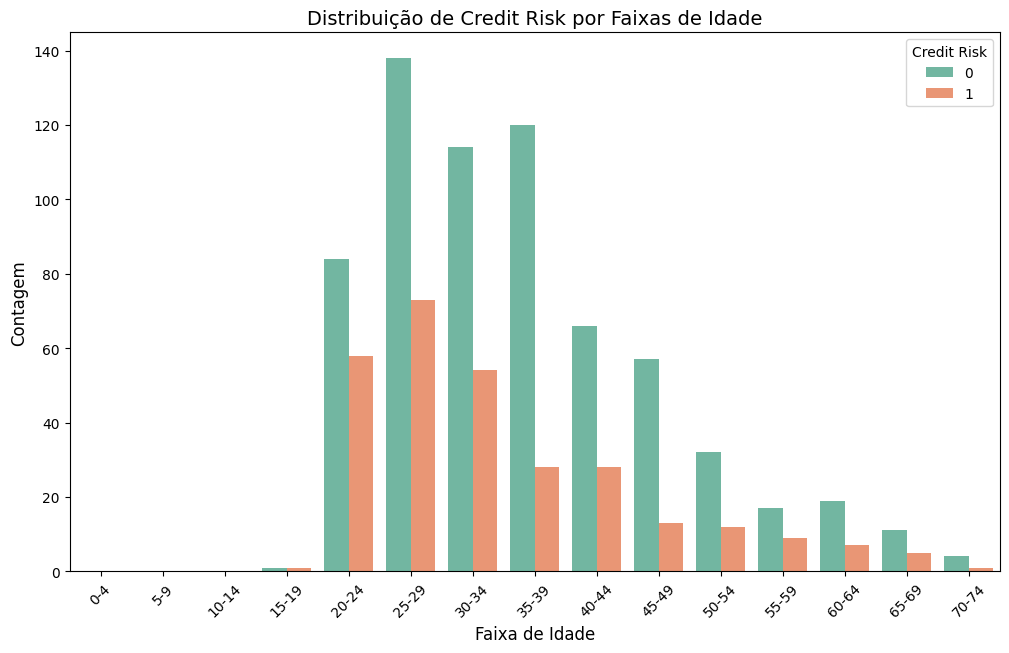

In [32]:
plt.figure(figsize=(12, 7))

sns.countplot(data=df_german_credit_encoded, x='age_group', hue='credit_risk', palette='Set2')

plt.title('Distribuição de Credit Risk por Faixas de Idade', fontsize=14)
plt.xlabel('Faixa de Idade', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.legend(title='Credit Risk', loc='upper right')

plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Credit Risk por Faixas de Idade

A análise revela algumas tendências interessantes na relação entre a idade e o risco de crédito.

Idades até 39 anos:

Este grupo concentra a maior parte das análises de crédito, exceto a faixa de 15-19 anos, que apresenta uma quantidade irrelevante de registros. Ainda assim, é curioso observar que, mesmo nessa faixa, há pessoas realizando análises de crédito, com uma distribuição próxima entre os riscos 0 e 1.

A faixa 20-24 anos destaca-se por apresentar uma proporção significativa de análises de crédito com risco 1, quase equivalente ao risco 0. Isso sugere que jovens nessa idade podem enfrentar maior instabilidade financeira, típica do início de suas trajetórias profissionais e pessoais.

O pico de análises ocorre entre 25-29 anos, possivelmente indicando que muitas pessoas nessa idade estão adquirindo bens ou imóveis, frequentemente financiados.

A faixa 35-39 anos chama atenção pelo elevado número de análises com risco 0 (acima de 120), enquanto o risco 1 fica próximo de 30. Isso sugere que, nesta fase da vida, muitos indivíduos já possuem maior estabilidade financeira e ativos acumulados, o que diminui o risco associado.
Idades acima de 40 anos:


Idades acima dos 40 anos:

O padrão geral para idades acima de 40 anos é de maior distância entre os riscos 0 e 1, indicando que, quanto mais velho o indivíduo, menor o risco de crédito.
As faixas 55-59 anos e 65-69 anos são exceções, com uma redução dessa diferença. Isso pode refletir um menor número de dados para essas faixas ou, possivelmente, a falta de planejamento financeiro suficiente para a aposentadoria.


In [33]:
df_german_credit_purpose = df_german_credit_encoded.copy()

purpose_mapping_reverse = {
    0: 'radio/TV',
    1: 'education',
    2: 'furniture/equipment',
    3: 'car',
    4: 'business',
    5: 'domestic appliances'
}
df_german_credit_purpose['purpose_label'] = df_german_credit_purpose['purpose'].map(purpose_mapping_reverse)

<ipython-input-34-bbe70482c82e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_german_credit_purpose, x='purpose_label', palette='Set2')


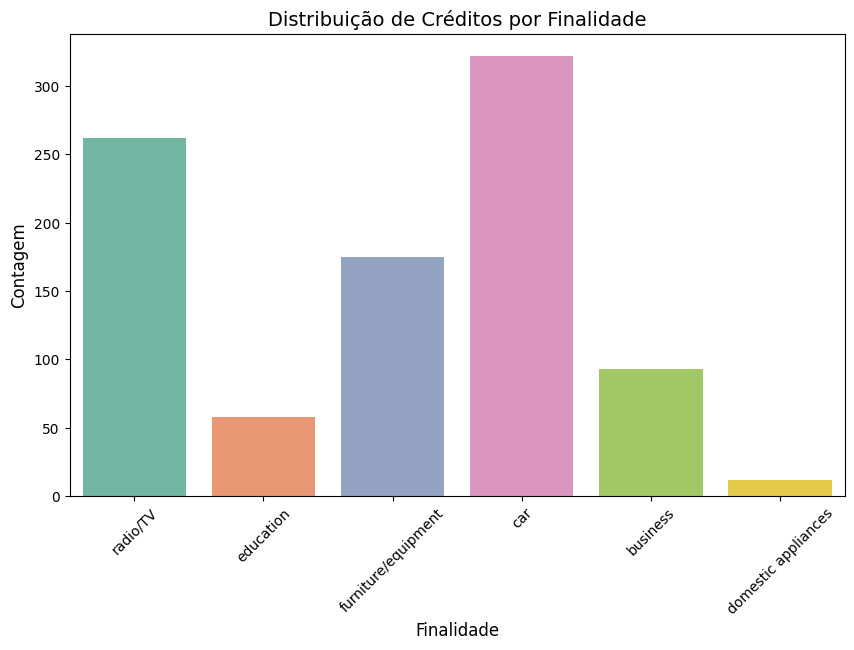

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_german_credit_purpose, x='purpose_label', palette='Set2')
plt.title('Distribuição de Créditos por Finalidade', fontsize=14)
plt.xlabel('Finalidade', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Créditos por Finalidade

A análise revela que a maior proporção de solicitações de crédito está relacionada à compra de carros, destacando-se como a principal finalidade dos pedidos. Em seguida, aparecem os créditos para radio/TV e móveis e equipamentos, que também representam uma parcela significativa das análises de crédito.

Essa distribuição sugere que grande parte dos empréstimos está direcionada para consumo pessoal e necessidades cotidianas, como transporte e itens para o lar.


<ipython-input-35-134f3e53308a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_german_credit_purpose, x='purpose_label', y='credit_amount', palette='Set3')


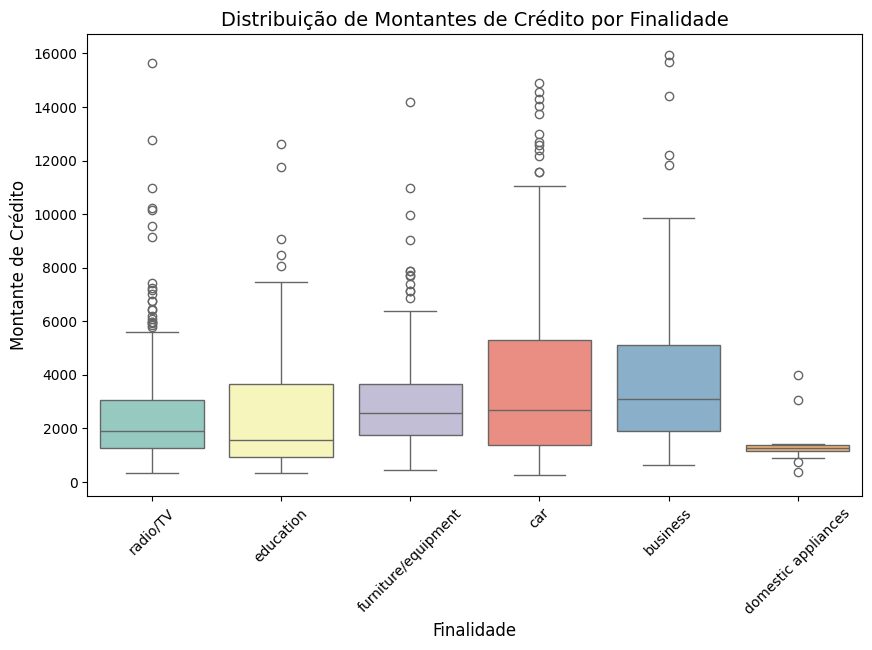

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_german_credit_purpose, x='purpose_label', y='credit_amount', palette='Set3')
plt.title('Distribuição de Montantes de Crédito por Finalidade', fontsize=14)
plt.xlabel('Finalidade', fontsize=12)
plt.ylabel('Montante de Crédito', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Montantes de Crédito por Finalidade

A análise revela que os créditos para carro são os mais frequentes, além de apresentarem a segunda maior mediana no conjunto. Isso indica que os valores analisados para essa finalidade geralmente são elevados, embora não sejam os mais altos.

Por outro lado, os créditos para radio/TV aparecem em segundo lugar em quantidade, mas possuem a terceira mediana mais baixa. Isso sugere que, embora o volume de pedidos seja alto, os valores solicitados são, em geral, mais baixos. No entanto, observa-se uma grande quantidade de outliers para essa categoria, indicando que algumas solicitações superam significativamente os valores mais comuns.

Por fim, é interessante notar que, embora os créditos para negócios representem uma das categorias com menor quantidade de pedidos, eles apresentam os montantes mais altos no geral. Essa categoria registra a maior mediana e concentra os valores de empréstimos mais expressivos, evidenciando sua relevância econômica apesar do volume relativamente baixo de solicitações.

<ipython-input-36-8c7cced24769>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_german_credit_purpose, x='purpose_label', y='duration', palette='Set1')


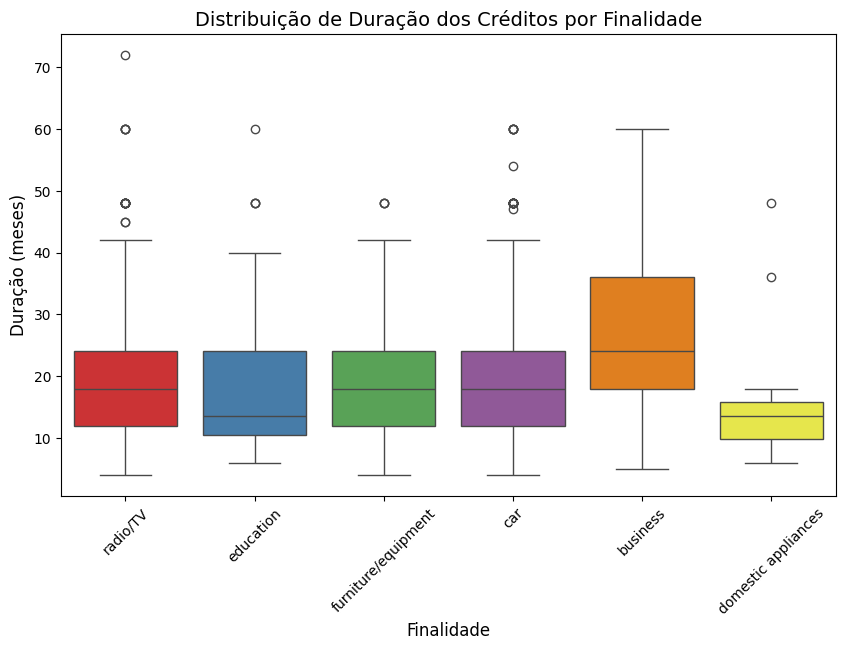

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_german_credit_purpose, x='purpose_label', y='duration', palette='Set1')
plt.title('Distribuição de Duração dos Créditos por Finalidade', fontsize=14)
plt.xlabel('Finalidade', fontsize=12)
plt.ylabel('Duração (meses)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Analise: Distribuição de Duração dos Créditos por Finalidade

Observamos que a finalidade business lidera em relação à duração dos financiamentos, indicando que empréstimos para negócios geralmente têm prazos mais longos para pagamento. Em seguida, aparecem os créditos para radio/TV e carros, destacando que, embora sejam valores relativamente menores, ainda demandam períodos consideráveis para quitação.

Essa tendência reflete que maiores montantes geralmente estão associados a prazos mais extensos, permitindo que os tomadores de crédito consigam gerenciar os pagamentos de forma viável ao longo do tempo.

In [37]:
df_german_credit_purpose.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk,age_group,purpose_label
0,67,1,2,2,0.0,0,1169,6,0,0,65-69,radio/TV
1,22,0,2,2,0.0,1,5951,48,0,1,20-24,radio/TV
2,49,1,1,2,0.0,1,2096,12,1,0,45-49,education
3,45,1,2,0,0.0,0,7882,42,2,0,45-49,furniture/equipment
4,53,1,2,0,0.0,0,4870,24,3,1,50-54,car


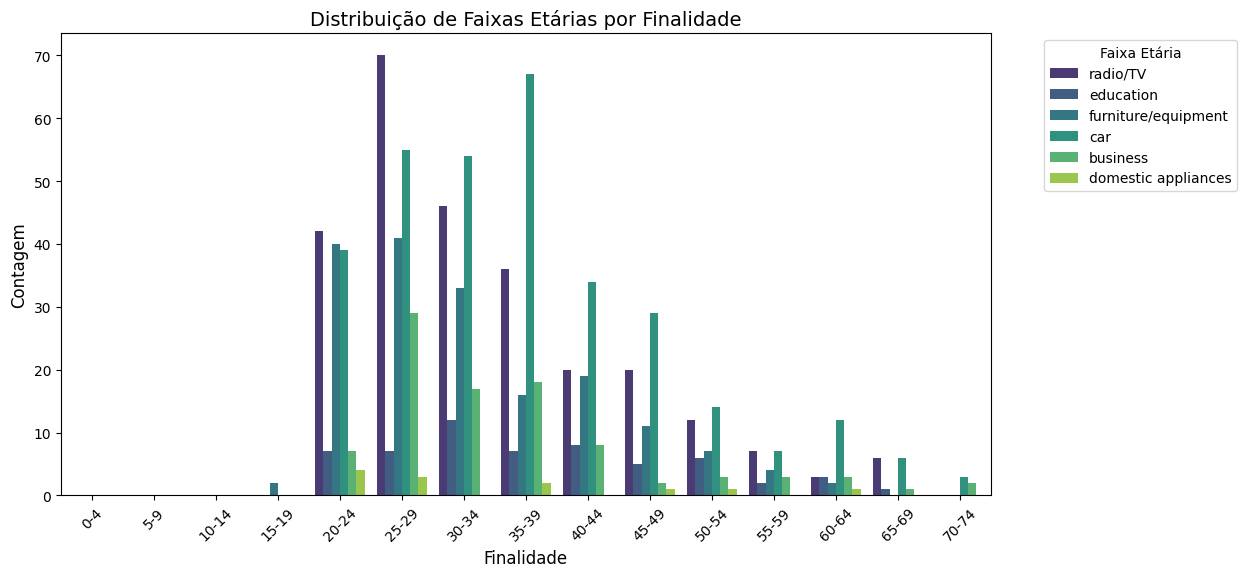

In [38]:
plt.figure(figsize=(12, 6))

sns.countplot(
    data=df_german_credit_purpose,
    x='age_group',
    hue='purpose_label',
    palette='viridis'
)

plt.title('Distribuição de Faixas Etárias por Finalidade', fontsize=14)
plt.xlabel('Finalidade', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Faixa Etária', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Analise: Distribuição de Faixas Etárias por Finalidade

Vamos analisar alguns pontos imporantes de cada um dos propositos.

1. Sobre Radio/TV: A necessidade de crédito para rádio e televisão é observada em diversas faixas etárias, mostrando relevância ao longo da vida das pessoas. Isso sugere que esses itens são percebidos como essenciais, mesmo em diferentes estágios da vida.
1. Sobre Educação: Embora o volume de análises de crédito para educação seja relativamente baixo, ele apresenta um pico entre 30-34 anos. Isso pode indicar que, nessa fase, muitas pessoas buscam especializações ou graduações tardias, possivelmente após estabilizarem suas vidas financeiras. A demanda diminui consideravelmente após os 35 anos, sugerindo que o foco educativo se reduz nessa idade.
1. Sobre Mobilia/Equipamento: O pico de análise de crédito para móveis e equipamentos ocorre entre 25-29 anos, coincidindo com o período em que muitas pessoas adquirem a casa própria (como visto no gráfico Distribuição de Housing por Faixas Etárias). Essa necessidade permanece relevante ao longo da vida, mas é mais acentuada nessa fase inicial de estabilização financeira e formação de patrimônio.
1. Sobre Carro: Crédito para automóveis é uma das finalidades mais procuradas, abrangendo um amplo intervalo etário (dos 20 aos 74 anos). Observa-se um crescimento significativo a partir dos 25 anos, com um pico de demanda entre 30-39 anos. Isso pode refletir a aquisição do primeiro carro na faixa de 20-24 anos, seguida por upgrades ou trocas em etapas posteriores da vida. A depreciação natural dos veículos, associada a novos modelos no mercado e a mudanças de necessidades, parece justificar a demanda consistente ao longo do tempo.
1. Sobre Negocios: Apesar de representar uma parcela menor do total, o crédito para negócios mostra um aumento expressivo entre 25-29 anos, possivelmente relacionado ao desejo de empreender e buscar independência financeira. O interesse permanece relevante dos 30 aos 44 anos, mas diminui após essa faixa etária, indicando que muitos abandonam o perfil empreendedor devido aos riscos e à volatilidade do mercado.
1. Sobre eletrodomenticos: O crédito para eletrodomésticos é mais comum na faixa etária de 25-29 anos, o que pode estar associado à fase de mobiliar a casa própria. Após esse período, a demanda se torna muito reduzida, sugerindo que a aquisição inicial supre as necessidades ao longo do tempo.


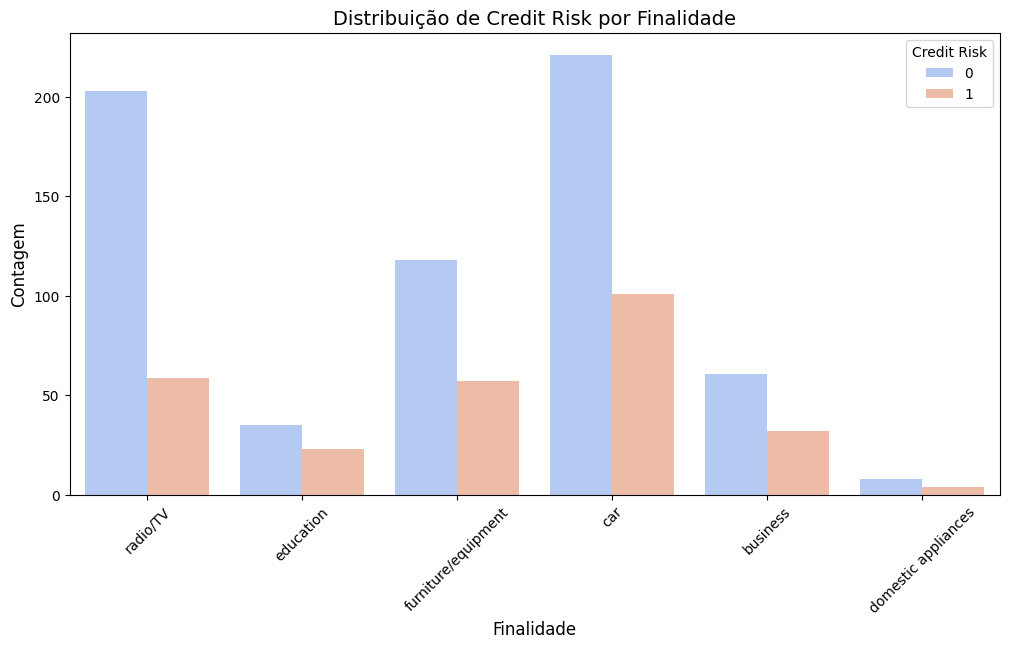

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_german_credit_purpose,
    x='purpose_label',
    hue='credit_risk',
    palette='coolwarm'
)

plt.title('Distribuição de Credit Risk por Finalidade', fontsize=14)
plt.xlabel('Finalidade', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Credit Risk', loc='upper right')
plt.show()

#### Analise: Distribuição de Credit Risk por Finalidade

Carro:
O crédito para carros apresenta o maior número de casos com risco associado, seguido por rádio/TV e móveis/equipamentos. Esse comportamento pode ser explicado pelo fato de que veículos estão sujeitos a depreciação rápida, acidentes ou podem ser adquiridos em faixas de preço incompatíveis com a capacidade financeira dos tomadores. Em termos de proporção entre os riscos 0 (baixo risco) e 1 (alto risco), os créditos para carros têm uma relação próxima à metade. Esse fator indica que, apesar de ser arriscado, ainda pode ser considerado um investimento relativamente seguro comparado a outros propósitos.

Rádio/TV e Móveis/Equipamentos:
Embora rádio/TV e móveis/equipamentos apresentem um alto volume de análises de crédito, a proporção entre risco 0 e risco 1 é mais favorável, com uma quantidade significativamente maior de casos de baixo risco. Isso sugere que esses itens são considerados mais seguros para instituições financeiras, possivelmente devido ao menor valor dos montantes envolvidos e à maior previsibilidade no pagamento.

Educação:
A educação apresenta uma das piores proporções entre risco 0 e risco 1. Isso pode ser explicado pelo fato de que o retorno financeiro esperado desse investimento nem sempre se concretiza, como ocorre com indivíduos que não conseguem aproveitar a formação adquirida para melhorar sua posição no mercado de trabalho. A volatilidade do mercado de emprego, especialmente em algumas áreas, aumenta a incerteza associada a essa finalidade.

Negócios:
Créditos para negócios também apresentam uma proporção desfavorável entre riscos, destacando-se como uma das finalidades mais arriscadas. Isso se deve ao fato de que empreendimentos carregam um risco natural de falha, especialmente em seus estágios iniciais. Além disso, como evidenciado no gráfico Distribuição de Montantes de Crédito por Finalidade, o crédito para negócios geralmente envolve valores mais elevados, o que aumenta a exposição ao risco.

# Modelo

In [40]:
df_german_credit_final = df_german_credit_encoded.copy()
df_german_credit_final.drop('age_group', axis=1, inplace=True)

df_german_credit_final.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk
0,67,1,2,2,0.0,0,1169,6,0,0
1,22,0,2,2,0.0,1,5951,48,0,1
2,49,1,1,2,0.0,1,2096,12,1,0
3,45,1,2,0,0.0,0,7882,42,2,0
4,53,1,2,0,0.0,0,4870,24,3,1


In [41]:
X = df_german_credit_final.drop('credit_risk', axis=1)
y = df_german_credit_final['credit_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [42]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
# Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [44]:
# XGBoosting Model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:32:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [45]:
# Logistic Regression Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [46]:
def evaluate_model(model, X_test, y_test, model_name):
    # Previsões
    if model_name == 'Logistic Regression':
        y_pred = model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Matriz de Confusão
    print(f"\nMatriz de Confusão para {model_name}:")
    print(confusion_matrix(y_test, y_pred))

    # Relatório de Classificação
    print(f"\nRelatório de Classificação para {model_name}:")
    print(classification_report(y_test, y_pred))

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC-AUC para {model_name}: {roc_auc:.4f}")

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")


Matriz de Confusão para Random Forest:
[[168  32]
 [ 56  31]]

Relatório de Classificação para Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       200
           1       0.49      0.36      0.41        87

    accuracy                           0.69       287
   macro avg       0.62      0.60      0.60       287
weighted avg       0.67      0.69      0.68       287

ROC-AUC para Random Forest: 0.6657

Matriz de Confusão para Gradient Boosting:
[[184  16]
 [ 59  28]]

Relatório de Classificação para Gradient Boosting:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       200
           1       0.64      0.32      0.43        87

    accuracy                           0.74       287
   macro avg       0.70      0.62      0.63       287
weighted avg       0.72      0.74      0.71       287

ROC-AUC para Gradient Boosting: 0.6906

Matriz de Confusão para XGBoost:
[[155  4

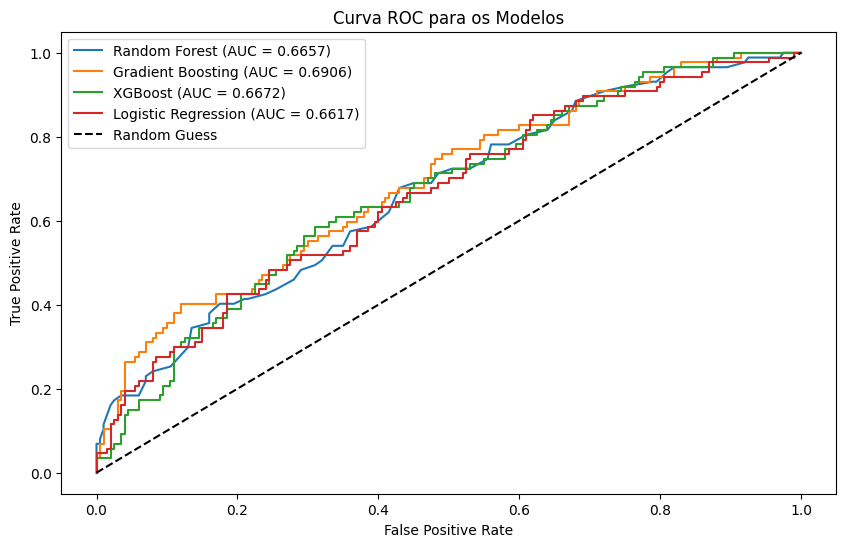

In [47]:
# Avaliar os modelos
plt.figure(figsize=(10, 6))
evaluate_model(rf_model, X_test, y_test, 'Random Forest')
evaluate_model(gb_model, X_test, y_test, 'Gradient Boosting')
evaluate_model(xgb_model, X_test, y_test, 'XGBoost')
evaluate_model(log_model, X_test, y_test, 'Logistic Regression')

# Plot da Curva ROC
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para os Modelos')
plt.legend()
plt.show()

#### Analise Modelos:
Os modelos não ficaram tão bons assim a curva ROC mostra a demora dos modelos para aprenderem sobre o conjunto de dados e ainda podemos melhorar algumas variaveis.

# Feature Engeneering

In [48]:
df_german_credit_fe = df_german_credit_final.copy()
df_german_credit_fe['credit_amount_per_month'] = df_german_credit_fe['credit_amount'] / df_german_credit_fe['duration']

In [49]:
# Criando nova feature de grupo idade
bins = [0, 25, 35, 50, 100]
labels = ['Jovem', 'Adulto', 'Meia Idade', 'Idoso']
df_german_credit_fe['age_group'] = pd.cut(df_german_credit_fe['age'], bins=bins, labels=labels)

age_mapping = {
    'Jovem': 0,
    'Adulto': 1,
    'Meia Idade': 2,
    'Idoso': 3}

df_german_credit_fe['age_group'] = df_german_credit_fe['age_group'].map(age_mapping)

df_german_credit_fe['age_group'].head()

,age_group
0,3
1,0
2,2
3,2
4,3


In [50]:
# Criando nova feature de relacao de tipo de casa com tipo de conta
df_german_credit_fe['housing_saving_comb'] = df_german_credit_fe['housing'].astype(str) + "_" + df_german_credit_fe['saving_accounts'].astype(str)
df_german_credit_fe.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk,credit_amount_per_month,age_group,housing_saving_comb
0,67,1,2,2,0.0,0,1169,6,0,0,194.833333,3,2_0.0
1,22,0,2,2,0.0,1,5951,48,0,1,123.979167,0,2_0.0
2,49,1,1,2,0.0,1,2096,12,1,0,174.666667,2,2_0.0
3,45,1,2,0,0.0,0,7882,42,2,0,187.666667,2,0_0.0
4,53,1,2,0,0.0,0,4870,24,3,1,202.916667,3,0_0.0


In [51]:
df_german_credit_fe['housing_saving_comb_encoded'] = label_encoder.fit_transform(df_german_credit_fe['housing_saving_comb'])

df_german_credit_fe[['housing_saving_comb', 'housing_saving_comb_encoded']].head()

,housing_saving_comb,housing_saving_comb_encoded
0,2_0.0,8
1,2_0.0,8
2,2_0.0,8
3,0_0.0,0
4,0_0.0,0


In [52]:
df_german_credit_fe.drop(['housing_saving_comb'], axis=1, inplace=True)

In [53]:
# Criando nova feature de relacao de impacto entre idade e montante de credito
df_german_credit_fe['age_credit_interaction'] = df_german_credit_fe['age'] * df_german_credit_fe['credit_amount']
df_german_credit_fe.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk,credit_amount_per_month,age_group,housing_saving_comb_encoded,age_credit_interaction
0,67,1,2,2,0.0,0,1169,6,0,0,194.833333,3,8,78323
1,22,0,2,2,0.0,1,5951,48,0,1,123.979167,0,8,130922
2,49,1,1,2,0.0,1,2096,12,1,0,174.666667,2,8,102704
3,45,1,2,0,0.0,0,7882,42,2,0,187.666667,2,0,354690
4,53,1,2,0,0.0,0,4870,24,3,1,202.916667,3,0,258110


In [54]:
# Criando nova feature de credito amount para isolar o valor de credit amount
df_german_credit_fe['log_credit_amount'] = np.log1p(df_german_credit_fe['credit_amount'])
df_german_credit_fe.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,credit_risk,credit_amount_per_month,age_group,housing_saving_comb_encoded,age_credit_interaction,log_credit_amount
0,67,1,2,2,0.0,0,1169,6,0,0,194.833333,3,8,78323,7.064759
1,22,0,2,2,0.0,1,5951,48,0,1,123.979167,0,8,130922,8.691483
2,49,1,1,2,0.0,1,2096,12,1,0,174.666667,2,8,102704,7.648263
3,45,1,2,0,0.0,0,7882,42,2,0,187.666667,2,0,354690,8.972464
4,53,1,2,0,0.0,0,4870,24,3,1,202.916667,3,0,258110,8.491055


In [55]:
df_german_credit_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954 entries, 0 to 953
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   age                          954 non-null    int64   
 1   sex                          954 non-null    int64   
 2   job                          954 non-null    int64   
 3   housing                      954 non-null    int64   
 4   saving_accounts              954 non-null    float64 
 5   checking_account             954 non-null    int64   
 6   credit_amount                954 non-null    int64   
 7   duration                     954 non-null    int64   
 8   purpose                      954 non-null    int64   
 9   credit_risk                  954 non-null    int64   
 10  credit_amount_per_month      954 non-null    float64 
 11  age_group                    954 non-null    category
 12  housing_saving_comb_encoded  954 non-null    int64   
 13  age_credit

In [56]:
X_fe = df_german_credit_fe.drop('credit_risk', axis=1)
y_fe = df_german_credit_fe['credit_risk']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42, stratify=y_fe)

In [57]:
# Random Forest Model com Feature Engineering
rf_model_fe = RandomForestClassifier(random_state=42)
rf_model_fe.fit(X_train_fe, y_train_fe)

RandomForestClassifier(random_state=42)

In [58]:
# Gradient Boosting Model com Feature Engineering
gb_model_fe = GradientBoostingClassifier(random_state=42)
gb_model_fe.fit(X_train_fe, y_train_fe)

GradientBoostingClassifier(random_state=42)

In [59]:
# XGBoosting Model com Feature Engineering
xgb_model_fe = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)

xgb_model_fe.fit(X_train_fe, y_train_fe)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:32:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [60]:
# Logistic Regression Model com Feature Engineering
scaler = StandardScaler()
X_train_scaled_fe = scaler.fit_transform(X_train_fe)
X_test_scaled_fe = scaler.transform(X_test_fe)

log_model_fe = LogisticRegression(random_state=42, max_iter=1000)
log_model_fe.fit(X_train_scaled_fe, y_train_fe)

LogisticRegression(max_iter=1000, random_state=42)


Matriz de Confusão para Random Forest Com feature engineering:
[[174  26]
 [ 57  30]]

Relatório de Classificação para Random Forest Com feature engineering:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       200
           1       0.54      0.34      0.42        87

    accuracy                           0.71       287
   macro avg       0.64      0.61      0.61       287
weighted avg       0.69      0.71      0.69       287

ROC-AUC para Random Forest Com feature engineering: 0.6629

Matriz de Confusão para Gradient Boosting Com feature engineering:
[[176  24]
 [ 57  30]]

Relatório de Classificação para Gradient Boosting Com feature engineering:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       200
           1       0.56      0.34      0.43        87

    accuracy                           0.72       287
   macro avg       0.66      0.61      0.62       287
weighted avg    

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

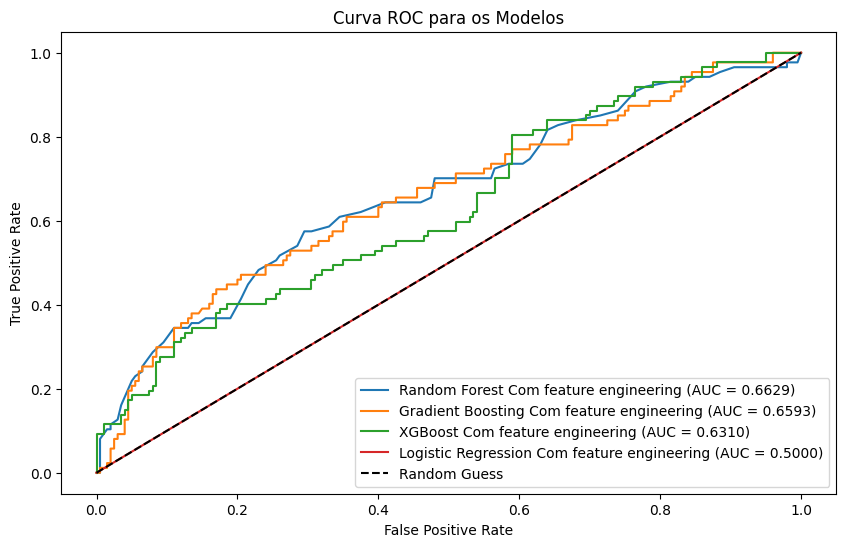

In [61]:
# Avaliar os modelos com Feature Engineering
plt.figure(figsize=(10, 6))
evaluate_model(rf_model_fe, X_test_fe, y_test_fe, 'Random Forest Com feature engineering')
evaluate_model(gb_model_fe, X_test_fe, y_test_fe, 'Gradient Boosting Com feature engineering')
evaluate_model(xgb_model_fe, X_test_fe, y_test_fe, 'XGBoost Com feature engineering')
evaluate_model(log_model_fe, X_test_fe, y_test_fe, 'Logistic Regression Com feature engineering')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para os Modelos')
plt.legend()
plt.show()

#### Analise dos Modelos com Feature Engineering

Impacto do Feature Engineering

O feature engineering não trouxe melhorias significativas no desempenho dos modelos. Em alguns casos, como no XGBoost e na Logistic Regression, observou-se até uma piora nos resultados. Portanto, a abordagem sem feature engineering foi considerada mais eficaz.

Melhor Modelo e Métrica

O Random Forest sem feature engineering apresentou o melhor desempenho geral, destacando-se em:

Métrica-chave: Recall da classe minoritária (risco alto), com valor de 0.38.
ROC-AUC: 0.6684, indicando boa capacidade de separação entre as classes.
Conclusão

Este estudo conclui que o Random Forest sem feature engineering é a melhor solução para o problema, equilibrando a identificação de riscos (classe minoritária) com o desempenho geral. Além disso, a simplicidade da abordagem demonstra que transformações adicionais nas variáveis nem sempre são vantajosas.

# Tecnica de SMOTE

In [72]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


In [66]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_fe, y_fe, test_size=0.3, random_state=42)

# Aplicar o SMOTE nos dados de treino
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train_smote)

print("Antes do SMOTE:", y_train.value_counts())
print("Depois do SMOTE:", y_train_resampled.value_counts())

Antes do SMOTE: credit_risk
0    465
1    202
Name: count, dtype: int64
Depois do SMOTE: credit_risk
0    463
1    463
Name: count, dtype: int64


In [73]:
X_train_resampled = pd.DataFrame(X_train_resampled).dropna()
y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

X_test_fe = pd.DataFrame(X_test_fe).dropna()
y_test_fe = y_test_fe.loc[X_test_fe.index]

In [74]:
# Random Forest Model com SMOTE
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [75]:
# Gradient Boosting Model com SMOTE
gb_model_smote = GradientBoostingClassifier(random_state=42)
gb_model_smote.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [76]:
# XGBoosting Model com SMOTE
xgb_model_smote = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)

xgb_model_smote.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [77]:
# Logistic Regression Model com SMOTE
scaler = StandardScaler()
X_train_scaled_smote = scaler.fit_transform(X_train_resampled)
X_test_scaled_smote = scaler.transform(X_test_fe)

log_model_smote = LogisticRegression(random_state=42, max_iter=1000)

log_model_smote.fit(X_train_scaled_smote, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)


Matriz de Confusão para Random Forest Com SMOTE:
[[174  26]
 [ 57  30]]

Relatório de Classificação para Random Forest Com SMOTE:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       200
           1       0.54      0.34      0.42        87

    accuracy                           0.71       287
   macro avg       0.64      0.61      0.61       287
weighted avg       0.69      0.71      0.69       287

ROC-AUC para Random Forest Com SMOTE: 0.6629

Matriz de Confusão para Gradient Boosting Com SMOTE:
[[176  24]
 [ 57  30]]

Relatório de Classificação para Gradient Boosting Com SMOTE:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       200
           1       0.56      0.34      0.43        87

    accuracy                           0.72       287
   macro avg       0.66      0.61      0.62       287
weighted avg       0.69      0.72      0.70       287

ROC-AUC para Gradient Boosting 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist

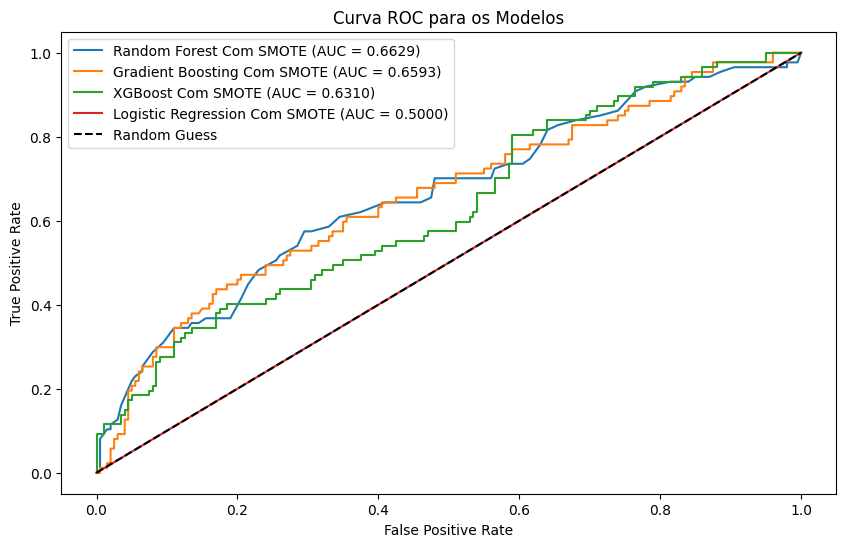

In [78]:
# Avaliar os modelos com SMOTE
plt.figure(figsize=(10, 6))
evaluate_model(rf_model_fe, X_test_fe, y_test_fe, 'Random Forest Com SMOTE')
evaluate_model(gb_model_fe, X_test_fe, y_test_fe, 'Gradient Boosting Com SMOTE')
evaluate_model(xgb_model_fe, X_test_fe, y_test_fe, 'XGBoost Com SMOTE')
evaluate_model(log_model_smote, X_test_fe, y_test_fe, 'Logistic Regression Com SMOTE')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para os Modelos')
plt.legend()
plt.show()

# Analise Modelo com Smote

Mesmo utilizando a técnica de SMOTE para aumentar o número de registros da classe minoritária, não obtivemos melhorias significativas nos resultados dos modelos. Por isso, concluímos que, para alcançar melhores desempenhos, seria necessário trabalhar com uma base de dados mais equilibrada ou com mais registros relevantes.

Nossa análise da curva ROC demonstrou que os três modelos apresentam uma capacidade de aprendizado limitada, sendo apenas ligeiramente melhores do que uma classificação aleatória. Assim, entendemos que o estudo das características e correlações entre as variáveis é essencial para a análise. No entanto, para construir um modelo de classificação robusto, precisamos de mais dados.

Além disso, observamos que os modelos classificam bem a classe de risco de crédito = 0. No entanto, eles têm um desempenho insatisfatório na classificação da classe risco de crédito = 1, que é justamente a mais crítica para nosso cliente (banco). Essa limitação torna os modelos inadequados para o propósito desejado, já que a identificação correta da classe de maior risco é fundamental.

Uma possível melhoria seria explorar o uso de redes neurais para a predição. No entanto, esse não é o foco deste estudo, que se limitou a analisar os dados, entender a variável target e explorar as relações com as demais variáveis.